# Прогноз погоды LSTM сетью
Мы будем пользоваться реализацией LSTM сети в Keras. Подключим все библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Данные о погоде

Будем использовать набор данных Jena Climate dataset, собранный в [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).

Данные содержат 14 признаков, таких как температура, давление, влажность и др., записанные через каждые 10 минут на метеостанции "Weather Station, Max Planck Institute for Biogeochemistry in Jena, Germany" с 10 Января 2009 по 31 Декабря 2016.

В таблице ниже дано описание этих данных.

Номер| Признак      |Формат             |Описание
-----|---------------|-------------------|-----------------------
1    |Дата\Время      |01.01.2009 00:10:00|дата и время записи
2    |p (mbar)       |996.52             |Давление в миллиБарах.
3    |T (degC)       |-8.02              |Температура в градусах Цельсия
4    |Tpot (K)       |265.4              |Температура в градусах Кельвина
5    |Tdew (degC)    |-8.9               |Температура в градусах Цельсия от точки росы (зависит от влажности).
6    |rh (%)         |93.3               |Относительная влажность.
7    |VPmax (mbar)   |3.33               |Давление насыщенного пара
8    |VPact (mbar)   |3.11               |Давление пара
9    |VPdef (mbar)   |0.22               |Разница давлений насыщенного и ненасыщенного пара
10   |sh (g/kg)      |1.94               |Удельная влажность
11   |H2OC (mmol/mol)|3.12               |Концентрация пара
12   |rho (g/m ** 3) |1307.75            |Плотность воздуха
13   |wv (m/s)       |1.03               |Скорость ветра
14   |max. wv (m/s)  |1.75               |Максимальная скорость ветра speed
15   |wd (deg)       |152.3              |Направление ветра

Загрузим их. Данные находятся в csv файле в zip-архиве.

In [2]:
from zipfile import ZipFile # для работы с архивами
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"  # адрес
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip") # загрузка
zip_file = ZipFile(zip_path) # получаем архив
zip_file.extractall() # распаковываем
csv_path = "jena_climate_2009_2016.csv" # путь к файлу

df = pd.read_csv(csv_path) # читаем его в DataFrame

13568290/13568290 [==============================] - 0s 0us/step


# Визуализация данных

Посмотрим на данные. Обратим внимание на аномалии.

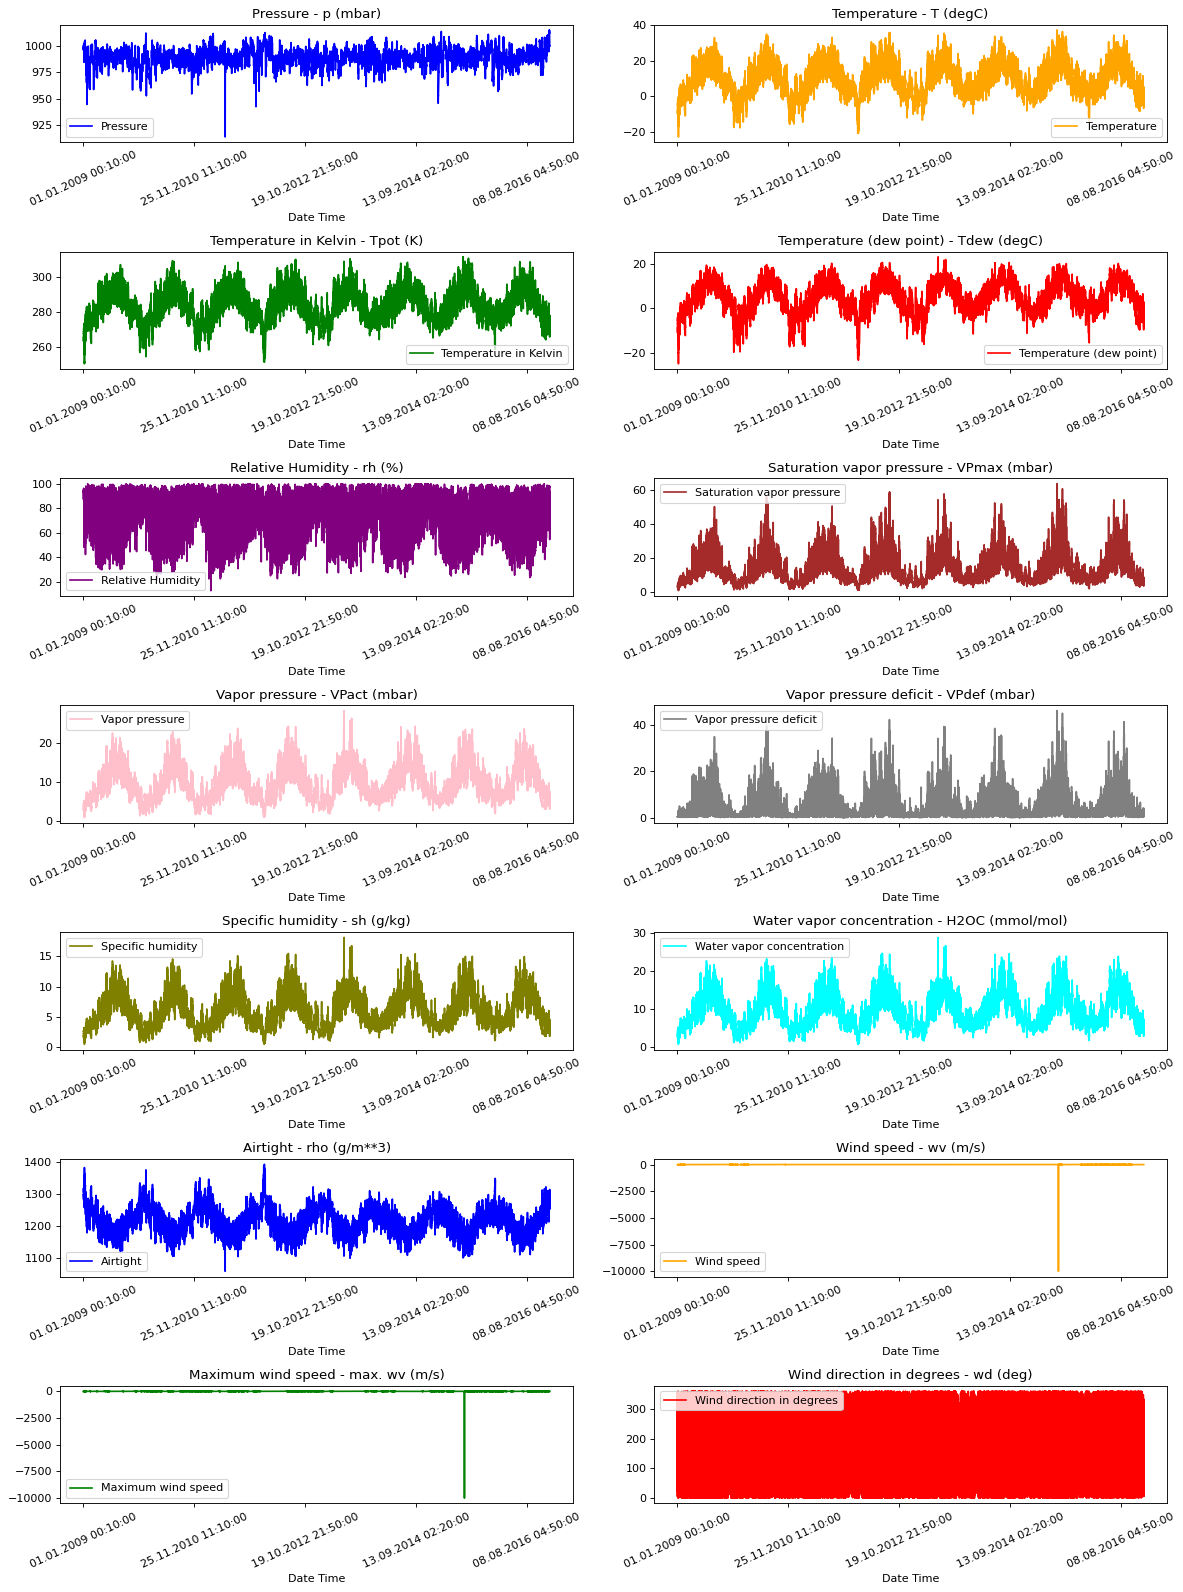

In [3]:
# названия параметров
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]
# их обозначения
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]
#  цвета
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
# поле с датой\временем
date_time_key = "Date Time"

#  функция для визуализации
def show_raw_visualization(data):
    time_data = data[date_time_key] # дата\время
    # подграфики 7 на 2
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)): # перебираем все параметры
        key = feature_keys[i] # текущий параметр
        c = colors[i % (len(colors))] # цвет его выбирается циклично
        t_data = data[key] # значение параметра
        t_data.index = time_data # индекс как дата
        t_data.head()
        # рисуем параметр
        ax = t_data.plot(
            ax=axes[i // 2, i % 2], # номер подграфика
            color=c, # цвет
            title="{} - {}".format(titles[i], key), # заголовок
            rot=25, # поворот текста
        )
        ax.legend([titles[i]]) # легенда графика
    plt.tight_layout() # компактное расположение подграфиков


show_raw_visualization(df) #  рисуем



Посмотрим на корреляцию признаков.

In [ ]:
df.iloc[:,1:].head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


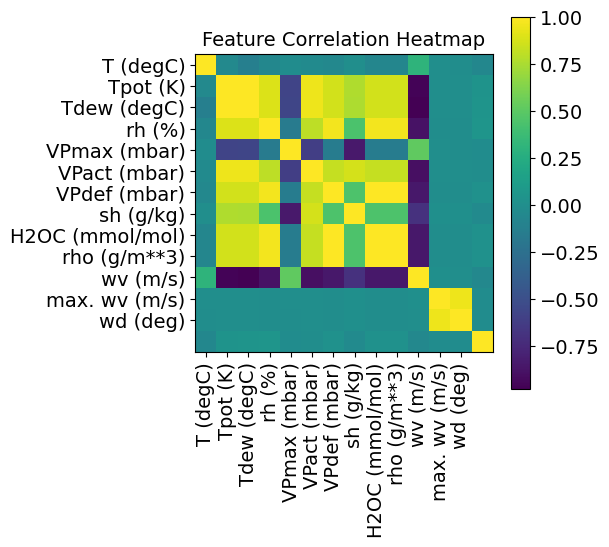

In [4]:
# функция рисования карты влияния
def show_heatmap(data):
    plt.matshow(data.corr()) #  считаем корреляцию признаков и рисуем ее на карте
    # при отображении первый столбец, дату\время, уберем.
    plt.xticks(range(data.shape[1]-1), data.columns[1:], fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]-1), data.columns[1:], fontsize=14)

    cb = plt.colorbar() # цветовая ось
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df.iloc[:,1:]) # рисуем


# Предобработка данных

В данных примерно 300 000 примеров, записанных каждый 10 минут, что составляет 6 штук в час.
Погода не может изменяться так быстро, так что нет необходимости так часто измерять данные. Перезапишем их, реже, один пример в час с помощью аргумента `sampling_rate` утилиты `timeseries_dataset_from_array`. Это сократит объем данных и, значит, время обучения.

Будем записывать последние 720 временных отсчета (720/6=120 часов) и предсказывать температуру через 72 отсчета (72/6=12 часов).

Значения признаков находятся в существенно разных диапазонах, нормализуем их, приведя к одному диапазону. Для этого вычтем среднее значение и поделим на разброс.

71.5 % данных будет использовано для обучения, аргументом `split_fraction` этот процент можно поменять.

In [5]:
split_fraction = 0.715  # доля данных для обучения
train_split = int(split_fraction * int(df.shape[0])) #  индекс последнего обучающего данного
step = 6 # величина шага переоцифровки

past = 720 # количество данных в наблюдении
future = 72 # горизонт (время) прогноза
learning_rate = 0.001 # шаг обучения
batch_size = 256 # размер пакета
epochs = 10 # количество эпох

#  функция нормализации
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0) # среднее
    data_std = data[:train_split].std(axis=0) #  разброс
    return (data - data_mean) / data_std # нормализуем


Из карты влияния видно, что некоторые признаки строго связаны между собой, а значит не несут полезной информации, их можно убрать. Проверьте самостоятельно с другим выбором.

In [6]:
# отбираем только параметры с номерами [0, 1, 5, 7, 8, 10, 11]
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split) # нормализуем по обучающим данным
features = pd.DataFrame(features)
features.head()
# разделяем на
train_data = features.loc[0 : train_split - 1] # обучающие
val_data = features.loc[train_split:] # и проверочные

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


# Подготовка набора данных

Указания учителя начинаются с 792 наблюдения (720 + 72).

In [7]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values # отбираем значения для входов (все 7 признаков)
y_train = features.iloc[start:end][[1]] # и для указаний учителя (температура имеет индекс 1)

sequence_length = int(past / step) # нужная длина последовательности

In [8]:
x_train.shape

(300693, 7)

Функция `timeseries_dataset_from_array` принимает последовательность и возвращает пакеты данных, в которых данные берутся каждые sampling_rate отсчетов.

In [9]:
# пакеты данных
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train, # входная последовательность
    y_train, # указания учителя
    sequence_length=sequence_length, # длина последовательности в пакете
    sampling_rate=step, # как часто брать данные из исходной последовательности
    batch_size=batch_size, # размер пакета
)

# Проверочный набор данных

В проверочном наборе не может быть последних 792 наблюдений (для них нет указаний учителя). Доступные указания учителя начинаются с 792 отсчета после train_split.

In [10]:
x_end = len(val_data) - past - future # последнее доступное наблюдение

label_start = train_split + past + future # начало указаний учителя

# отбираем
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values # примеры входов
y_val = features.iloc[label_start:][[1]] # указания учителя

# создаем пакеты
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


Метод take() позволяет вернуть поднабор данных из нескольких пакетов. Сам пакет это примеры входов и указания учителя. Проверим.

In [11]:
# один пакет
for batch in dataset_train.take(1):
    inputs, targets = batch
# размеры возвращаемых массивов
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


# Обучение
Создадим LSTM сеть используя слой [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) Keras с 32 нейронами. Мы решаем задачу регрессии, добавим полносвязный (Dense) слой, который соберет выходы всех LSTM нейронов.

In [12]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))  # слой входов
lstm_out = keras.layers.LSTM(32)(inputs) # рекуррентный слой
outputs = keras.layers.Dense(1)(lstm_out) # выходной полосвязный слой

# создаем модель нейронной сети
model = keras.Model(inputs=inputs, outputs=outputs)
# задаем параметры обучения
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary() # посмотрим на полученную сеть

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Видим в LSTM слое 5120 обучаемых параметра. Приведите расчет этого числа.

<details>

В слое 32 нейрона. У каждого 4 набора весов и 4 смещения.

Размер матрицы весов = (размер входа+число нейронов)*число нейронов.  

Размер входа 7 признаков.

Итого: ((7+32)весов + 1 смещение) * 4 набора * 32 нейрона = 5120 коэффициентов

</details>

Процесс обучения не быстрый (~30 минут), будем использовать `ModelCheckpoint` для регулярного сохранения прогресса обучения и `EarlyStopping` чтобы выйти из обучения, если ошибка на проверочных данных не улучшается.

In [ ]:
path_checkpoint = "model_checkpoint.h5" # файл для сохранения
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5) # ранний выход из обучения, если в течении 5 шагов ошибка проверки не улучшилась
# сохранение модели
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss", # за какой метрикой наблюдать
    filepath=path_checkpoint, # файл для сохранения
    verbose=1, # показывать ли информацию в командном окне
    save_weights_only=True, # сохранять ли только веса
    save_best_only=True,# сохранять ли только лучшую, по наблюдаемой метрике, сеть
)
# обучение
epochs=5 # увеличьте
history = model.fit(
    dataset_train, # набор данных для обучения
    epochs=epochs, # максимальное количество эпох
    validation_data=dataset_val, # набор данных для проверки
    callbacks=[es_callback, modelckpt_callback], # функции выполняемые в процессе обучения
)

Epoch 1/5
1172/1172 [==============================] - ETA: 0s - loss: 0.1951
Epoch 1: val_loss improved from inf to 0.14282, saving model to model_checkpoint.h5
1172/1172 [==============================] - 183s 155ms/step - loss: 0.1951 - val_loss: 0.1428
Epoch 2/5
1172/1172 [==============================] - ETA: 0s - loss: 0.1242
Epoch 2: val_loss improved from 0.14282 to 0.13591, saving model to model_checkpoint.h5
1172/1172 [==============================] - 182s 155ms/step - loss: 0.1242 - val_loss: 0.1359
Epoch 3/5
1172/1172 [==============================] - ETA: 0s - loss: 0.1150
Epoch 3: val_loss did not improve from 0.13591
1172/1172 [==============================] - 172s 147ms/step - loss: 0.1150 - val_loss: 0.1417
Epoch 4/5
1172/1172 [==============================] - ETA: 0s - loss: 0.1109
Epoch 4: val_loss did not improve from 0.13591
1172/1172 [==============================] - 181s 155ms/step - loss: 0.1109 - val_loss: 0.1384
Epoch 5/5
1172/1172 [=====================

После обучения нарисуем, как изменялась функция ошибки.

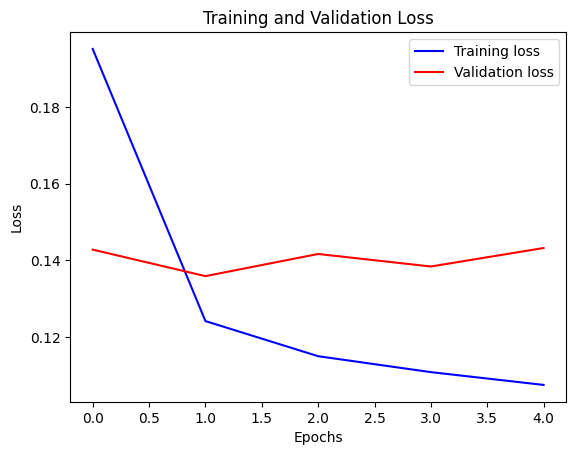

In [ ]:
# рисование функции ошибки
def visualize_loss(history, title):
    loss = history.history["loss"] # ошибка обучения
    val_loss = history.history["val_loss"] # ошибка проверки
    epochs = range(len(loss)) # число эпох действительно проведенных
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# рисуем
visualize_loss(history, "Training and Validation Loss")

# Прогноз

После обучения построим прогноз.

8/8 [==============================] - 1s 13ms/step


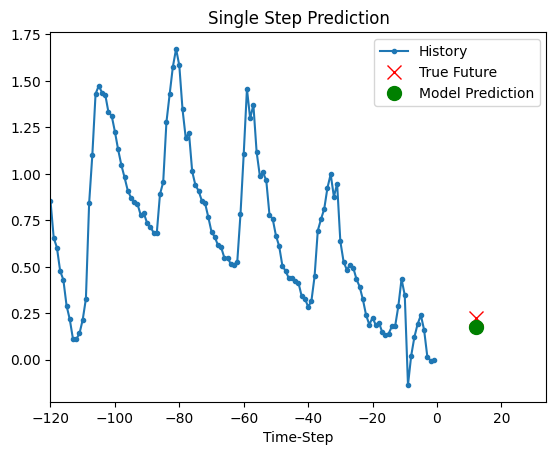

8/8 [==============================] - 0s 12ms/step


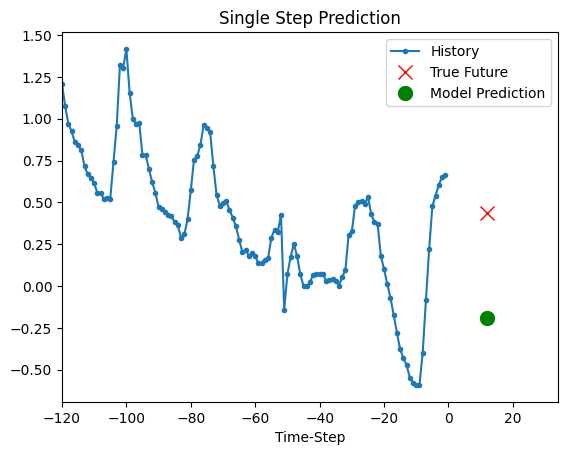

8/8 [==============================] - 0s 12ms/step


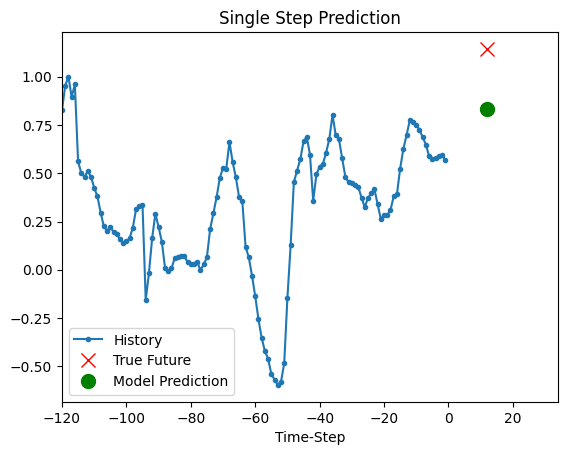

8/8 [==============================] - 0s 12ms/step


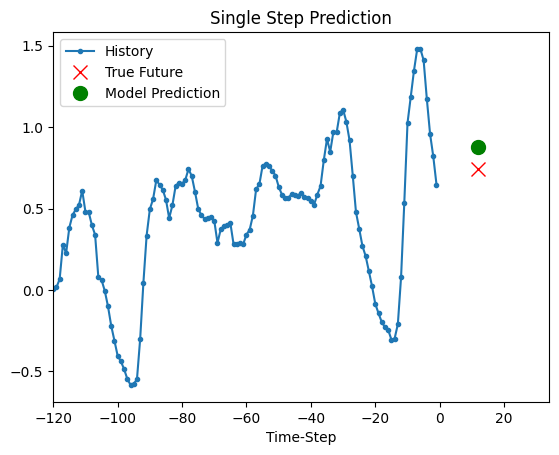

8/8 [==============================] - 0s 13ms/step


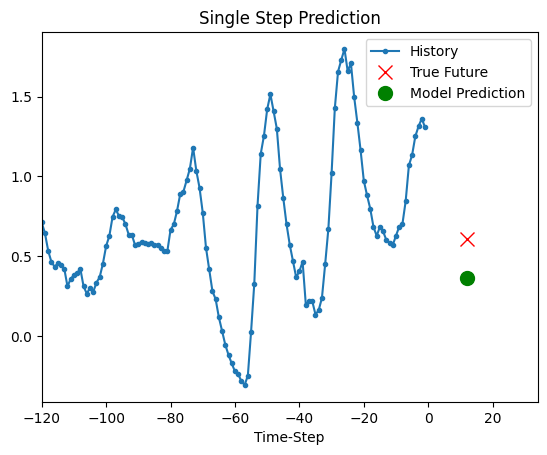

8/8 [==============================] - 0s 13ms/step


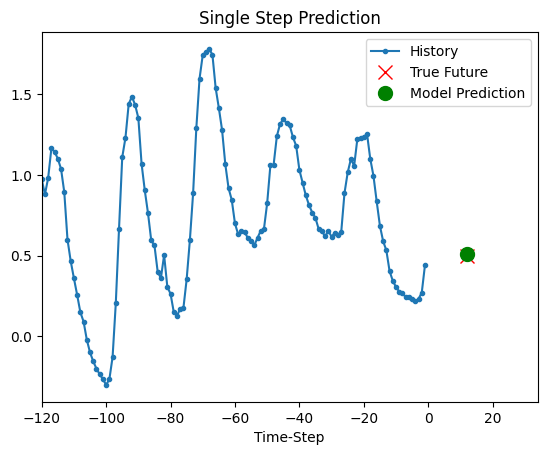

8/8 [==============================] - 0s 13ms/step


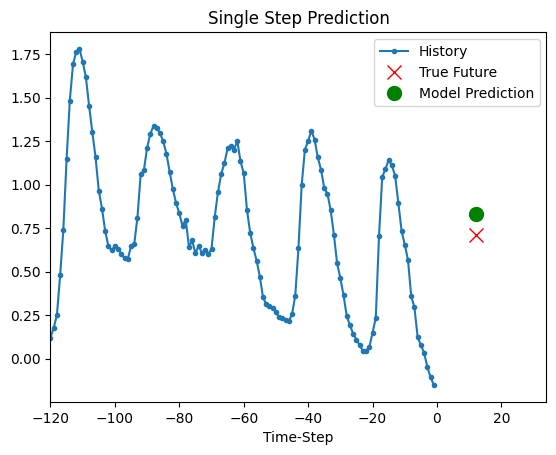

8/8 [==============================] - 0s 13ms/step


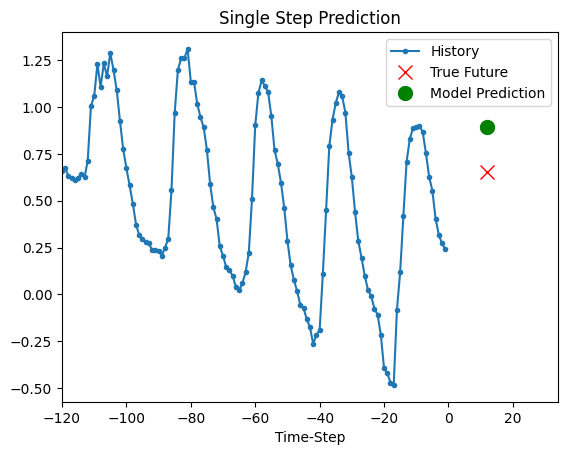

8/8 [==============================] - 0s 14ms/step


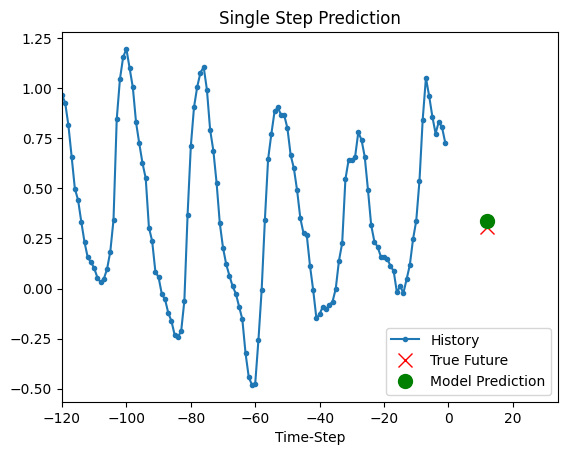

8/8 [==============================] - 0s 13ms/step


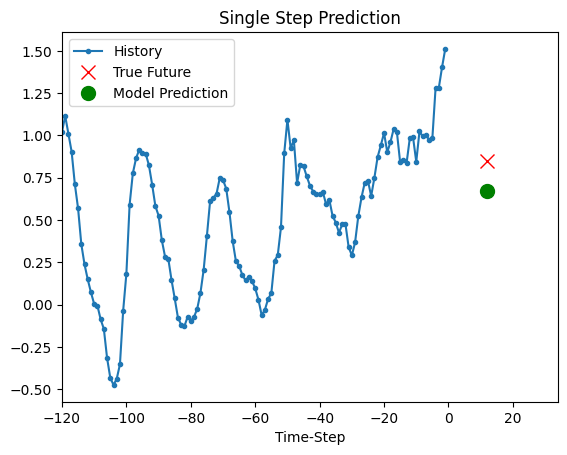

8/8 [==============================] - 0s 19ms/step


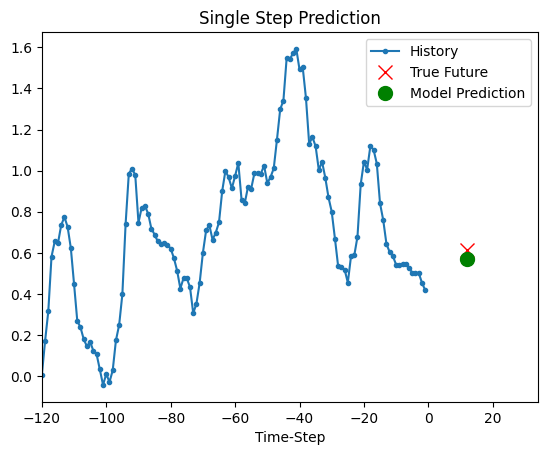

8/8 [==============================] - 0s 19ms/step


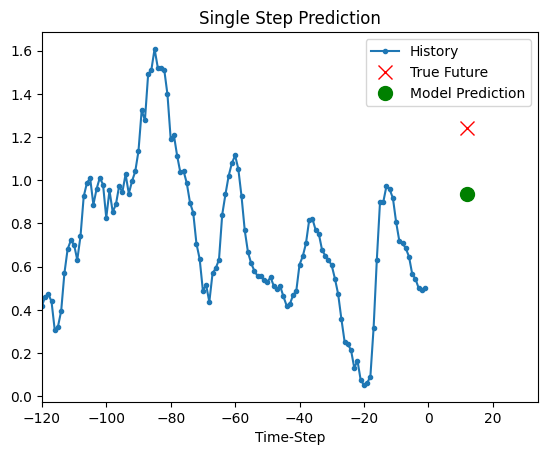

8/8 [==============================] - 0s 19ms/step


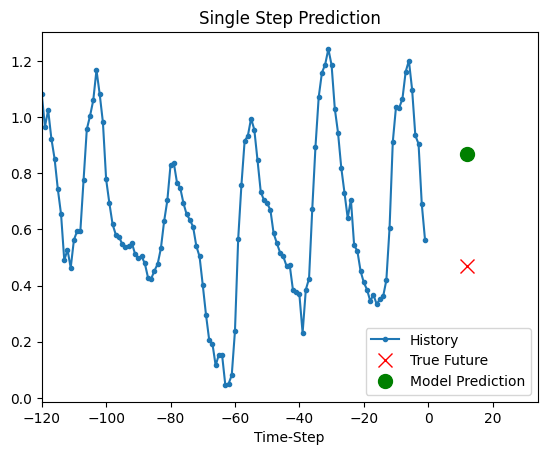

8/8 [==============================] - 0s 22ms/step


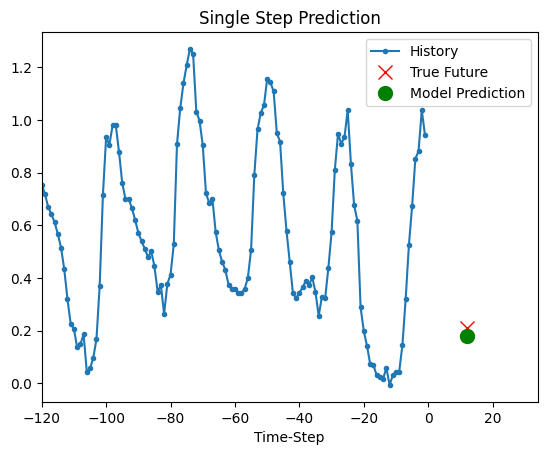

8/8 [==============================] - 0s 14ms/step


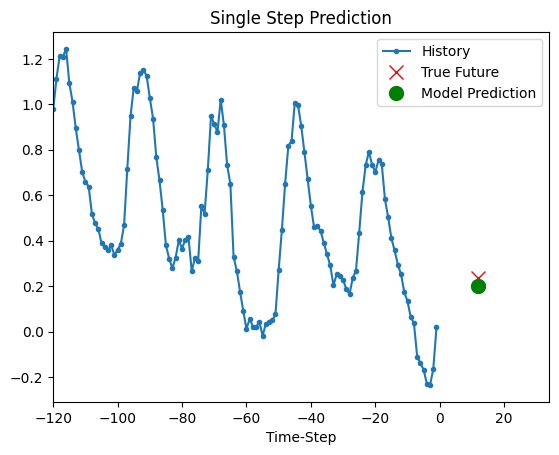

In [ ]:
# рисование графика прогноза
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"] # подписи графиков, первый - 120 отсчета входов, второй - настоящее значение прогноза, третий - полученное значение прогноза.
    marker = [".-", "rx", "go"] # маркеры для графиков
    time_steps = list(range(-(plot_data[0].shape[0]), 0)) # временные отсчеты, отрицательные - используемые для входа, положительные - прогноз
    if delta:
        future = delta # как далеко рисовать прогноз (исключительно для наглядности, прогноз идет на 72 такта)
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data): # перебираем все три графика
        if i: # для второго и третьего строим маркеры
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else: # для первого рисуем сплошной линией, данные вытягиваем в строку, метод flatten()
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

# несколько пакетов из проверочного набора

for x, y in dataset_val.take(15):
    #  x[0][:, 1].numpy() - входы, переведенные в numpy массив (только один пример с индексом [0] из пакета). индекс [:, 1] определяет температуру
    #  y[0].numpy(), - указание учителя для него
    #  model.predict(x)[0] - прогноз для него
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

На графиках, только для наглядности, прогноз придвинут поближе к 0 отсчету, в действительности прогноз строится на 72 отсчета в будущее.

Все не так плохо, есть случаи, когда прогноз почти идеален, но есть и такие, когда прогноз далек от действительности. Попробуйте самостоятельно улучшить прогноз за счет:
- выбора других признаков
- большего времени обучения
- более частого выбора данных
- другой архитектуры сети (числа нейронов)  

# Ссылки

Использованы и адаптированы материалы:


https://keras.io/examples/timeseries/timeseries_weather_forecasting


